In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
# import re 
from sklearn.model_selection import train_test_split

%matplotlib inline

In [217]:
train_labels = pd.read_csv("C:/Users/HP/OneDrive/Documents/DrivenData/train_labels.csv")
train_values = pd.read_csv("C:/Users/HP/OneDrive/Documents/DrivenData/train_values.csv")
test_values = pd.read_csv("C:/Users/HP/OneDrive/Documents/DrivenData/test_values.csv")

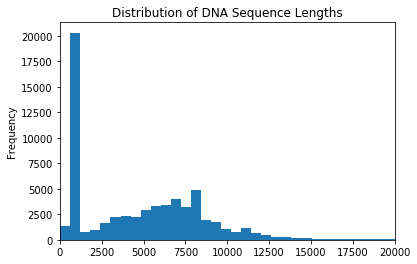

In [218]:
sequence_lengths = train_values.sequence.apply(len)
sequence_lengths.plot(kind="hist", title='Distribution of DNA Sequence Lengths', 
    bins=100,
    xlim=(0, 20000))

In [219]:
train_values.iloc[:, 2:].apply(pd.value_counts)

,bacterial_resistance_ampicillin,bacterial_resistance_chloramphenicol,bacterial_resistance_kanamycin,bacterial_resistance_other,bacterial_resistance_spectinomycin,copy_number_high_copy,copy_number_low_copy,copy_number_unknown,growth_strain_ccdb_survival,growth_strain_dh10b,...,species_budding_yeast,species_fly,species_human,species_mouse,species_mustard_weed,species_nematode,species_other,species_rat,species_synthetic,species_zebrafish
0.0,19590,60506,48706,62078,58592,18750,57313,50059,61841,61285,...,61417,61478,36890,57732,61978,62322,56381,61949,55170,61742
1.0,43427,2511,14311,939,4425,44267,5704,12958,1176,1732,...,1600,1539,26127,5285,1039,695,6636,1068,7847,1275


In [220]:
sorted_binary_features = train_values.iloc[:, 1:].mean().sort_values()

ax = sorted_binary_features.plot(kind='barh', stacked=True, figsize=(5, 12), title='Prevalence of Binary Features')
ax.set_xlabel('Proportion of sequences');

In [221]:
# number of genes in the plasmid
def gene_numbers(sequence):
    c=0
    tata_box = ["TATATAT", "TATAAAA", "TATATAA", "TATAAAT"]
    for indx, seq in enumerate(sequence):
        for box in tata_box:
            if box == sequence[indx: indx+7]:
                c +=1
    return c

In [222]:
train_values["gene_number"] = train_values.sequence.apply(gene_numbers)
train_values["sequence_lengths"] = train_values.sequence.apply(len)

In [223]:
def occurence_A(row):
    c = 0
    for base in row:
        if base == "A":
            c+= 1
    return c

def occurence_T(row):
    c = 0
    for base in row:
        if base == "T":
            c+= 1
    return c

def occurence_G(row):
    c = 0
    for base in row:
        if base == "G":
            c+= 1
    return c

def occurence_C(row):
    c = 0
    for base in row:
        if base == "C":
            c+= 1
    return c

def occurence_N(row):
    c = 0
    for base in row:
        if base == "N":
            c+= 1
    return c

In [224]:
# train_values["A_occurrence"] = train_values.sequence.apply(occurence_A)
# train_values["T_occurrence"] = train_values.sequence.apply(occurence_T)
train_values["G_occurrence"] = train_values.sequence.apply(occurence_G)
train_values["C_occurrence"] = train_values.sequence.apply(occurence_C)
train_values["N_occurrence"] = train_values.sequence.apply(occurence_N)

In [225]:
train_labels.set_index("sequence_id", inplace=True)
lab_ids = pd.DataFrame(train_labels.idxmax(axis=1), columns=['lab_id'])

lab_ids.reset_index(inplace=True)
features_lab = lab_ids.merge(train_values, on="sequence_id")
bases = ["A", "T", "C", "G", "N"]

In [226]:
from itertools import permutations
n = 5
subsequences = [''.join(permutation) for permutation in permutations(bases, r=n)]

In [227]:
def get_ngram_features(data, subsequences):
    """Generates counts for each subsequence.

    Args:
        data (DataFrame): The data you want to create features from. Must include a "sequence" column.
        subsequences (list): A list of subsequences to count.

    Returns:
        DataFrame: A DataFrame with one column for each subsequence.
    """
    features = pd.DataFrame(index=data.index)
    for subseq in subsequences:
        features[subseq] = data.sequence.str.count(subseq)
    return features

In [228]:
ngram_features = get_ngram_features(train_values, subsequences)

In [229]:
all_features = ngram_features.join(features_lab.drop('sequence', axis=1))

In [230]:
def top10_accuracy_scorer(estimator, X, y):
    """A custom scorer that evaluates a model on whether the correct label is in 
    the top 10 most probable predictions.

    Args:
        estimator (sklearn estimator): The sklearn model that should be evaluated.
        X (numpy array): The validation data.
        y (numpy array): The ground truth labels.

    Returns:
        float: Accuracy of the model as defined by the proportion of predictions
               in which the correct label was in the top 10. Higher is better.
    """
    probas = estimator.predict_proba(X)
    top10_idx = np.argpartition(probas, -10, axis=1)[:, -10:]
    top10_preds = estimator.classes_[top10_idx]
    mask = top10_preds == y.reshape((y.size, 1))
    top_10_accuracy = mask.any(axis=1).mean()
 
    return top_10_accuracy

In [231]:
# Rename our feature array
X = all_features.drop(["lab_id", "sequence_id"], axis=1)

# Create our labels
y = all_features.lab_id.values.ravel()

In [240]:

X_train, X_test, y_train, y_test= train_test_split(X, y,
test_size=0.2,
random_state=1)

In [ ]:
param_grid = {'max_depth': [2, 4, 6, 8], 'min_samples_leaf': [1, 2, 4, 6], 'criterion': ["gini", "entropy"]}

In [ ]:
rf_class = RandomForestClassifier(max_features='auto')

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

In [ ]:
# instantiate our RF Classifier
rf = RandomForestClassifier(
    min_samples_leaf=2,
    n_jobs=4, 
    n_estimators=1000,
    class_weight='balanced', # balance classes
    max_depth=8, # shallow tree depth to prevent overfitting
    random_state=0 # set a seed for reproducibility
)
# grid_rf_class = RandomizedSearchCV(
    # estimator=rf_class, param_distributions=param_grid, n_iter=5, scoring=top10_accuracy_scorer, n_jobs=None, 
    # iid='warn', refit=True, cv='warn', verbose=0, pre_dispatch='2*n_jobs', random_state=None, error_score='raise-deprecating',
    # return_train_score='warn')

In [233]:
import xgboost as xgb

In [234]:
xg_cl = xgb.XGBClassifier(n_estimators=10, seed=123)

In [235]:
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=1, verbosity=1)

In [236]:
top10_accuracy_scorer(xg_cl, X_test, y_test)

0.6777213582989527

In [258]:
ngram_test_set = get_ngram_features(test_values, subsequences)

test_values["sequence_lengths"] = test_values.sequence.apply(len)
test_values["gene_number"] = test_values.sequence.apply(gene_numbers)

test_values["G_occurrence"] = test_values.sequence.apply(occurence_G)
test_values["C_occurrence"] = test_values.sequence.apply(occurence_C)
test_values["N_occurrence"] = test_values.sequence.apply(occurence_N)

features_test = test_values.drop(["sequence"], axis=1)


all_features_test = ngram_test_set.join(features_test.drop(["sequence_id"], axis=1))

In [268]:
f_names = xg_cl.get_booster().feature_names
all_features_test = all_features_test[f_names]

In [269]:
predictions = xg_cl.predict_proba(all_features_test)

In [270]:
submission_format = pd.read_csv("C:/Users/HP/OneDrive/Documents/DrivenData/submission_format_3TFRxH6.csv", index_col='sequence_id')

In [271]:
assert submission_format.shape == predictions.shape
assert (grid_rf_class.classes_ == submission_format.columns).all()

In [272]:
my_submission_3 = pd.DataFrame(data=predictions, 
                             columns=xg_cl.classes_, 
                             index=submission_format.index)

In [273]:
my_submission_3.to_csv('C:/Users/HP/OneDrive/Documents/DrivenData/submission_3.csv')